## Version 1
This is a DilBERT-base version, to better work with the emotions and layering of music lyrics.

In [ ]:
#pip install hf_xet

In [ ]:
import pandas as pd
import gensim
from transformers import pipeline, AutoTokenizer
from tqdm import tqdm

transformer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

def transformer_sentiment(text):
    if pd.isna(text):
        return None
    
    # Properly tokenize and truncate to max 512 tokens
    tokens = tokenizer.encode(text, truncation=True, max_length=512)
    truncated_text = tokenizer.decode(tokens, skip_special_tokens=True)
    
    result = transformer(truncated_text)[0]
    return result['score'] if result['label'] == 'POSITIVE' else -result['score']

In [ ]:
#df_subset['sentiment_score'] = df_subset['clean_lyrics'].apply(lambda lyric: transformer_sentiment(lyric.strip()) if pd.notna(lyric) else None)
df['sentiment_score'] = df['clean_lyrics'].apply(
    lambda lyric: transformer_sentiment(lyric.strip()) if pd.notna(lyric) else None
)

In [ ]:
df.head()

In [ ]:
df.to_csv("all_en_lyrics_processed.csv")

## Version 2 
### Batch processing for the large datasets

In [ ]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer
from tqdm import tqdm
import time
import pickle
import os
import torch

In [ ]:
transformer = pipeline("sentiment-analysis", 
                      model="distilbert-base-uncased-finetuned-sst-2-english",
                      device=0 if torch.cuda.is_available() else -1)  # Can we use on Great Lakes?

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
def transformer_sentiment_batch(texts, batch_size=32):
    results = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch = texts[i:i+batch_size]

        valid_texts = []
        valid_indices = []
        
        for j, text in enumerate(batch):
            if pd.notna(text) and text.strip():
                valid_texts.append(text.strip())
                valid_indices.append(j)
        
        if valid_texts:
            batch_results = transformer(valid_texts, truncation=True, max_length=512)

            batch_scores = [None] * len(batch)
            for idx, result in zip(valid_indices, batch_results):
                score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
                batch_scores[idx] = score
            
            results.extend(batch_scores)
        else:
            results.extend([None] * len(batch))
    
    return results

In [ ]:
def process_sample_first(df, sample_size=1000):
    """Process a sample first to estimate time and test the pipeline"""
    print(f"Processing sample of {sample_size} rows first...")
    
    sample_df = df.sample(n=min(sample_size, len(df)), random_state=42)
    
    start_time = time.time()
    sample_texts = sample_df['clean_lyrics'].tolist()
    sample_results = transformer_sentiment_batch(sample_texts, batch_size=16)
    end_time = time.time()
    
    processing_time = end_time - start_time
    estimated_total_time = (processing_time / sample_size) * len(df)
    
    print(f"Sample processing time: {processing_time:.2f} seconds")
    print(f"Estimated total time: {estimated_total_time/60:.2f} minutes")
    print(f"Successfully processed: {sum(1 for r in sample_results if r is not None)} out of {len(sample_results)}")
    
    return sample_results, estimated_total_time

In [ ]:
# Sample test - 28 min
sample_results, estimated_time = process_sample_first(df, sample_size=100)
    
if estimated_time > 3600:  # More than 1 hour
    print("Estimated time is very long. Consider using TextBlob for quick results:")
    df['sentiment_score_quick'] = quick_sentiment_analysis(df)

In [ ]:
# Simple batch processing
texts = df['clean_lyrics'].tolist()
df['sentiment_score'] = transformer_sentiment_batch(texts, batch_size=8)

In [ ]:
df

In [ ]:
df.to_csv('recession_artists_processed.csv')

## Version 
Trying a RoBERTa-base, which is for shorter texts like Twitter and social media posts.

In [ ]:
#pip install torch==2.6.0+cpu --index-url https://download.pytorch.org/whl/cpu

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
import pandas as pd

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [33]:
#def sentiment_analyzer2(text):
#    if pd.isna(text): return None
#    tokens = tokenizer(text[:512], return_tensors='pt', truncation=True)
#    output = model(**tokens)
#    scores = softmax(output.logits.detach().numpy()[0])
#    labels = ['negative', 'neutral', 'positive']
#    return dict(zip(labels, scores))

In [35]:
def sentiment_analyzer(text):
    if pd.isna(text): return None

    max_length = min(512, tokenizer.model_max_length)
    
    tokens = tokenizer(
        text, 
        return_tensors='pt', 
        truncation=True,
        max_length=max_length,
        padding=True
    )
    
    output = model(**tokens)
    scores = softmax(output.logits.detach().numpy()[0])
    labels = ['negative', 'neutral', 'positive']
    return dict(zip(labels, scores))

In [37]:
df = pd.read_csv('all_en_lyrics_processed.csv')

In [39]:
df['sentiment'] = df['clean_lyrics'].apply(sentiment_analyzer)

In [41]:
df['dominant_sentiment'] = df['sentiment'].apply(lambda x: max(x, key=x.get) if x else None)

In [ ]:
df

In [43]:
def map_sentiment_label(label):
    mapping = {
        'negative': -1,
        'neutral': 0,
        'positive': 1
    }
    return mapping.get(label, None)

In [45]:
df['sentiment_score'] = df['dominant_sentiment'].apply(map_sentiment_label)

In [53]:
sentiment_counts = df['sentiment_score'].value_counts()
print(sentiment_counts)

sentiment_score
 0.0    6902
-1.0    2504
 1.0    1404
Name: count, dtype: int64


In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_confidence(df):
    confidences = []
    for sentiment_dict in df['sentiment'].dropna():
        max_confidence = max(sentiment_dict.values())
        confidences.append(max_confidence)
    
    df_clean = df.dropna(subset=['sentiment']).copy()
    df_clean['confidence'] = confidences
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(confidences, bins=50, alpha=0.7)
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Confidence Scores')
    
    plt.subplot(1, 2, 2)
    sentiment_counts = df_clean['dominant_sentiment'].value_counts()
    plt.bar(sentiment_counts.index, sentiment_counts.values)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Low confidence predictions (potential errors)
    low_confidence = df_clean[df_clean['confidence'] < 0.5]
    print(f"Low confidence predictions: {len(low_confidence)} ({len(low_confidence)/len(df_clean)*100:.1f}%)")
    
    return df_clean

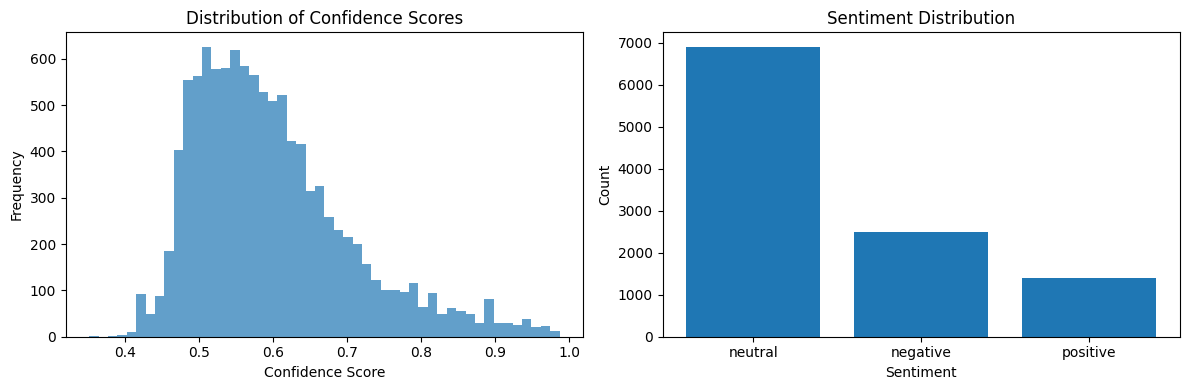

Low confidence predictions: 1797 (16.6%)


In [64]:
df_with_confidence = analyze_confidence(df)

In [55]:
df.to_csv('all_en_lyrics_processed_new.csv')